In [194]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
import imblearn


In [150]:
# read data
fraud_df = pd.read_csv("fraud_analyst_interview_exercise_-_v2.csv")
fraud_df = fraud_df.dropna()
warnings.simplefilter('ignore')  # deal and fix later
fraud_df['adjusted_acc_created_at'] = pd.to_datetime(
    fraud_df['adjusted_acc_created_at'])
fraud_df['adjusted_pmt_created_at'] = pd.to_datetime(
    fraud_df['adjusted_pmt_created_at'])
fraud_df["time_diff"] = fraud_df['adjusted_acc_created_at'] - \
    fraud_df['adjusted_pmt_created_at']


# Feature Engineering

In [151]:
# create binary variable based on whether the account was created AFTER the payment occured
fraud_df["creation_after_payment_flg"] = [1 if x >= dt.timedelta(0) else 0 for x in fraud_df["time_diff"]]


In [152]:
#create binary variable based on whether phone is version 6 or 10
fraud_df["is_version_6_or_10_flg"] = [1 if (x == 6) or (
    x == 10) else 0 for x in fraud_df["version"]]


In [153]:
# create binary variable based on whether merchant account is 0 

In [154]:
# create binary variable based on whether phone number/email/phone number is the same
fraud_df["same_phone_flg"] = (fraud_df["hashed_consumer_phone"] == fraud_df["hashed_buyer_phone"])
fraud_df["same_email_flg"] = (fraud_df["hashed_consumer_email"] == fraud_df["hashed_buyer_email"])  # 51/69
fraud_df["same_domain_flg"] = (fraud_df["consumer_email_domain"] == fraud_df["buyer_email_domain"])


In [155]:
fraud_df.dtypes

fraud_flag                            float64
payment_id                              int64
hashed_ip                              object
device                                 object
version                               float64
adjusted_pmt_created_at        datetime64[ns]
merchant_name                          object
hashed_consumer_id                     object
adjusted_acc_created_at        datetime64[ns]
amount                                  int64
hashed_buyer_email                     object
buyer_email_domain                     object
hashed_consumer_email                  object
consumer_email_domain                  object
hashed_buyer_phone                     object
hashed_consumer_phone                  object
consumer_phone_age                      int64
merchant_account_age                    int64
ltv                                     int64
hashed_zip                              int64
consumer_gender                        object
consumer_age                      

In [156]:
fraud_df.columns

Index(['fraud_flag', 'payment_id', 'hashed_ip', 'device', 'version',
       'adjusted_pmt_created_at', 'merchant_name', 'hashed_consumer_id',
       'adjusted_acc_created_at', 'amount', 'hashed_buyer_email',
       'buyer_email_domain', 'hashed_consumer_email', 'consumer_email_domain',
       'hashed_buyer_phone', 'hashed_consumer_phone', 'consumer_phone_age',
       'merchant_account_age', 'ltv', 'hashed_zip', 'consumer_gender',
       'consumer_age', 'time_diff', 'creation_after_payment_flg',
       'is_version_6_or_10_flg', 'same_phone_flg', 'same_email_flg',
       'same_domain_flg'],
      dtype='object')

In [157]:
cleaned_df = fraud_df.drop(columns=['adjusted_pmt_created_at', 'hashed_consumer_id',
               'adjusted_acc_created_at', 'hashed_buyer_email',
               'buyer_email_domain', 'hashed_consumer_email', 'consumer_email_domain',
                       'hashed_buyer_phone', 'hashed_consumer_phone', 'hashed_zip', 'version', 'time_diff', 'hashed_ip',"payment_id"])
cleaned_df.head()

,fraud_flag,device,merchant_name,amount,consumer_phone_age,merchant_account_age,ltv,consumer_gender,consumer_age,creation_after_payment_flg,is_version_6_or_10_flg,same_phone_flg,same_email_flg,same_domain_flg
1,0.0,Android,Red Shop,580,108,19,3800,Female,66,0,1,True,True,True
2,0.0,Android,Red Shop,680,112,0,0,Male,49,0,0,True,True,True
4,0.0,iPhone OS,Blue Shop,125400,13,0,0,Male,21,0,0,True,True,True
6,0.0,iPhone OS,Red Shop,1500,14,0,0,Female,30,0,0,True,True,True
7,0.0,iPhone OS,Red Shop,6000,19,904,2350,Male,21,0,0,True,True,True


In [158]:
cleaned_df =  pd.get_dummies(cleaned_df, columns=[
               "device", "consumer_gender", "merchant_name"])



In [159]:
cleaned_df.head()

,fraud_flag,amount,consumer_phone_age,merchant_account_age,ltv,consumer_age,creation_after_payment_flg,is_version_6_or_10_flg,same_phone_flg,same_email_flg,same_domain_flg,device_Android,device_Mac OS X,device_Windows NT,device_iPad; CPU OS,device_iPhone OS,consumer_gender_Female,consumer_gender_Male,merchant_name_Blue Shop,merchant_name_Red Shop
1,0.0,580,108,19,3800,66,0,1,True,True,True,1,0,0,0,0,1,0,0,1
2,0.0,680,112,0,0,49,0,0,True,True,True,1,0,0,0,0,0,1,0,1
4,0.0,125400,13,0,0,21,0,0,True,True,True,0,0,0,0,1,0,1,1,0
6,0.0,1500,14,0,0,30,0,0,True,True,True,0,0,0,0,1,1,0,0,1
7,0.0,6000,19,904,2350,21,0,0,True,True,True,0,0,0,0,1,0,1,0,1


In [160]:
# fraud_df.loc[(fraud_df['adjusted_pmt_created_at'] >= '2021-04-26')& (fraud_df['adjusted_pmt_created_at'] <= '2021-04-28')]
train_df = cleaned_df.iloc[np.where(np.isnan(fraud_df.fraud_flag ) == False)]
test_df = cleaned_df.iloc[np.where(np.isnan(fraud_df.fraud_flag) == True)]
# test_df


In [161]:
train_df = train_df.dropna()

In [162]:
train_df.head()

,fraud_flag,amount,consumer_phone_age,merchant_account_age,ltv,consumer_age,creation_after_payment_flg,is_version_6_or_10_flg,same_phone_flg,same_email_flg,same_domain_flg,device_Android,device_Mac OS X,device_Windows NT,device_iPad; CPU OS,device_iPhone OS,consumer_gender_Female,consumer_gender_Male,merchant_name_Blue Shop,merchant_name_Red Shop
1,0.0,580,108,19,3800,66,0,1,True,True,True,1,0,0,0,0,1,0,0,1
2,0.0,680,112,0,0,49,0,0,True,True,True,1,0,0,0,0,0,1,0,1
4,0.0,125400,13,0,0,21,0,0,True,True,True,0,0,0,0,1,0,1,1,0
6,0.0,1500,14,0,0,30,0,0,True,True,True,0,0,0,0,1,1,0,0,1
7,0.0,6000,19,904,2350,21,0,0,True,True,True,0,0,0,0,1,0,1,0,1


In [170]:
train_Y = train_df.iloc[:,0]
train_X = train_df.iloc[:,1:]


In [171]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.3, random_state=42)


# Classification/Decision tree

In [172]:
X_train

,amount,consumer_phone_age,merchant_account_age,ltv,consumer_age,creation_after_payment_flg,is_version_6_or_10_flg,same_phone_flg,same_email_flg,same_domain_flg,device_Android,device_Mac OS X,device_Windows NT,device_iPad; CPU OS,device_iPhone OS,consumer_gender_Female,consumer_gender_Male,merchant_name_Blue Shop,merchant_name_Red Shop
2002,6650,66,0,0,56,0,0,True,True,True,0,0,0,0,1,0,1,0,1
297,6000,163,208,2400,69,0,0,True,True,True,0,0,0,0,1,1,0,0,1
150,2699,39,0,0,49,0,0,True,True,True,1,0,0,0,0,0,1,0,1
911,800,32,726,2000,61,0,0,True,True,True,0,0,0,0,1,0,1,0,1
688,2900,28,0,0,44,1,0,True,True,True,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,500,106,182,85000,31,1,0,True,True,True,0,0,0,0,1,0,1,0,1
1681,4160,25,0,0,60,0,0,True,True,True,1,0,0,0,0,1,0,0,1
1115,2200,140,9,300,21,1,0,True,True,True,1,0,0,0,0,1,0,0,1
1896,15200,148,0,0,51,1,0,True,True,True,0,0,0,0,1,1,0,0,1


In [173]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#Predict the response for test dataset
y_val_pred = clf.predict(X_valid)

print("Accuracy:", metrics.accuracy_score(y_valid, y_val_pred))


Accuracy: 0.9980119284294234


In [189]:
metrics.roc_auc_score(y_valid, y_val_pred)


0.9989733059548255

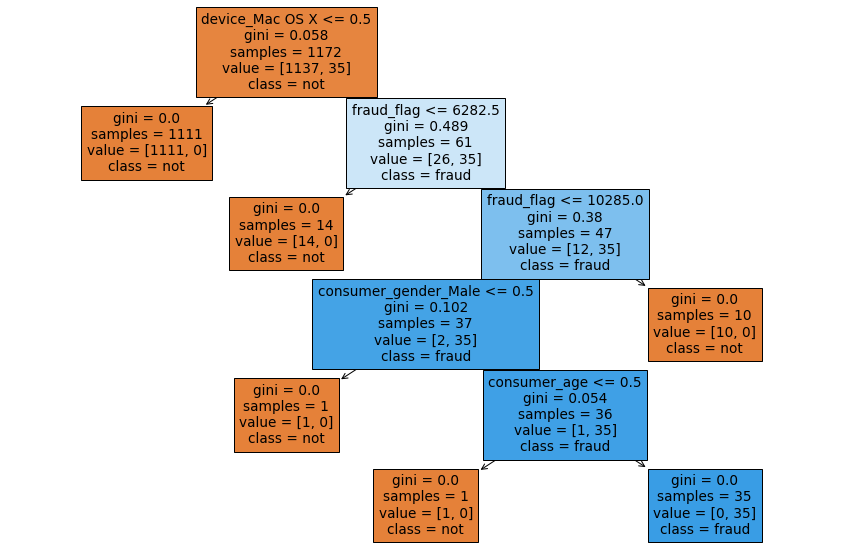

In [191]:

fig = plt.figure(figsize=(15, 10))
_ = tree.plot_tree(clf,
                   feature_names= train_df.columns,
                   class_names= ["not","fraud"],
                   filled=True)


# Random oversampling

In [196]:
# define oversampling strategy
from prometheus_client import Counter


oversample = imblearn.over_sampling.RandomOverSampler(
    sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train_X, train_Y)



In [198]:
len(X_over)

3248

# Baseline model: Logisitic regression 

# Baseline model 2 : Manual-rule-based

# Support Vector Machine